In [5]:
import os
from dotenv import  load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

### Connect to Database

In [2]:
load_dotenv()

database = os.getenv("DATABASE_NAME")
username = os.getenv("DATABASE_USERNAME")
password = os.getenv("DATABASE_PASSWORD")
host = os.getenv("DATABASE_HOST")
port = os.getenv("DATABASE_PORT")

In [3]:
try:
    engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{database}")
    conn = engine.connect()
    print("Connected Successfully")
except Exception as e:
    print("Unable to connect to database")
    print(e)

Connected Successfully


#### Queries

In [5]:
def execute_query(query):
    try:
        result = conn.execute(text(query))
        column_names = result.keys()
        data = result.fetchall()
        return pd.DataFrame(data, columns=column_names)
    except Exception as e:
        print("Unable to execute the query")
        print(e)

In [6]:
USER_QUERY = '''SELECT t.* FROM "Users" t ORDER BY id;'''
QUESTION_QUERY = '''SELECT t.* FROM "Questions" t'''

user_df = execute_query(USER_QUERY)
question_df = execute_query(QUESTION_QUERY)

### Plots

#### IQ Score Distribution

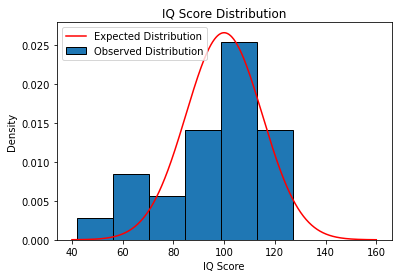

In [7]:
scores = user_df['score']
plt.hist(scores, bins='auto', density=True,edgecolor='black', label='Observed Distribution')
# IQ scores mean and standard deviation
mean = 100
std_dev = 15
# Create a range of x values to plot the normal distribution
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
# Compute the normal distribution (bell curve) with the given mean and standard deviation
y = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, y, 'r-', label='Expected Distribution')
plt.xlabel('IQ Score')
plt.ylabel('Density')
plt.title('IQ Score Distribution')
plt.legend()
plt.show()

In [8]:
score_mean = scores.mean()
score_median = scores.median()
score_std = scores.std()
score_max = scores.max()
score_min = scores.min()
print("IQ Score Statistics")
print(f"Max: {score_max}")
print(f"Min: {score_min}")
print(f"Mean: {score_mean}")
print(f"Median: {score_median}")
print(f"Standard Deviation: {score_std}")

IQ Score Statistics
Max: 127
Min: 42
Mean: 95.6
Median: 103.0
Standard Deviation: 21.929812280698318


#### Comparison between time left and IQ Score

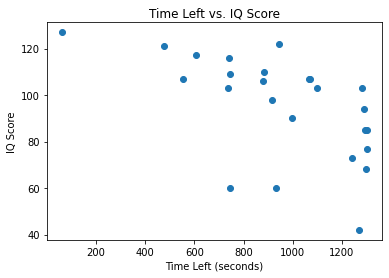

In [9]:
time_left = user_df['timeLeft']
scores = user_df['score']

# Create a scatter plot of time left vs. score
plt.scatter(time_left, scores)

# Label the axes and add a title
plt.xlabel('Time Left (seconds)')
plt.ylabel('IQ Score')
plt.title('Time Left vs. IQ Score')

# Show the plot
plt.show()

In [10]:
time_left_mean = time_left.mean()
time_left_median = time_left.median()
time_left_std = time_left.std()
time_left_max = time_left.max()
time_left_min = time_left.min()
print("Time left statistics")
print(f"Max: {time_left_max}")
print(f"Min: {time_left_min}")
print(f"Mean: {time_left_mean}")
print(f"Median: {time_left_median}")
print(f"Standard Deviation: {time_left_std}")

Time left statistics
Max: 1301
Min: 63
Mean: 948.76
Median: 945.0
Standard Deviation: 317.4689328632541


In [11]:
score_of_fastest = scores[time_left == time_left_max].values[0]
score_of_slowest = scores[time_left == time_left_min].values[0]
print(f"Score of fastest: {score_of_fastest}")
print(f"Score of slowest: {score_of_slowest}")

Score of fastest: 77
Score of slowest: 127


#### Correct/Incorrect Question Distribution

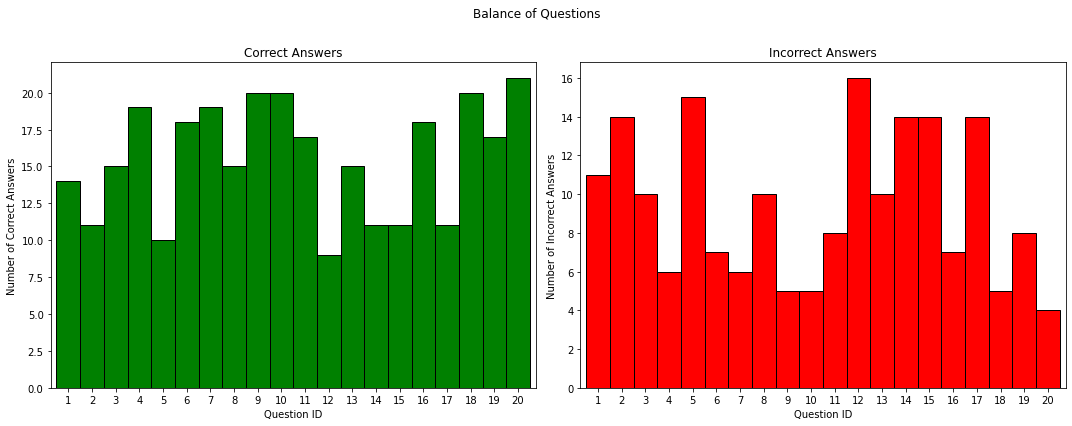

In [12]:
grouped_counts = question_df.groupby(['questionId', 'correct']).size().unstack(fill_value=0)

# Create a figure with two subplots (one for correct answers and one for incorrect answers)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Balance of Questions')

# Plot the distribution of correct answers
grouped_counts[True].plot(kind='bar', ax=ax1, color='g', rot=0,width=1,edgecolor='black')
ax1.set_title('Correct Answers')
ax1.set_xlabel('Question ID')
ax1.set_ylabel('Number of Correct Answers')

# Plot the distribution of incorrect answers
grouped_counts[False].plot(kind='bar', ax=ax2, color='r', rot=0,width=1,edgecolor='black')
ax2.set_title('Incorrect Answers')
ax2.set_xlabel('Question ID')
ax2.set_ylabel('Number of Incorrect Answers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

#### New (balanced) distribution of questions

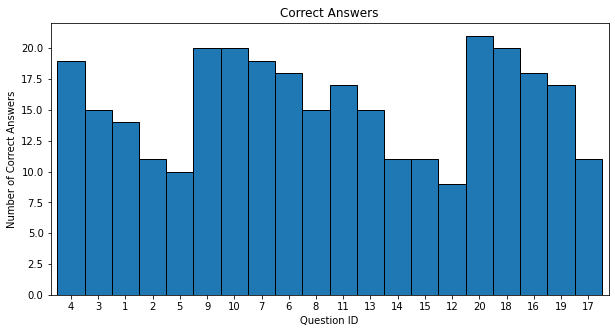

In [13]:
grouped_counts = question_df.groupby(['questionId', 'correct']).size().unstack(fill_value=0)
# Function to split DataFrame into chunks of n rows
def split_dataframe(df, chunk_size):
    return [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
# Split grouped_counts into chunks of 5 rows
grouped_counts_chunks = split_dataframe(grouped_counts, 5)
# Sort each chunk in descending order based on correct answers
sorted_chunks = [chunk.sort_values(by=True, ascending=False) for chunk in grouped_counts_chunks]
# Concatenate the sorted chunks back together
sorted_grouped_counts = pd.concat(sorted_chunks)
fig, ax1 = plt.subplots(1, figsize=(10, 5))
sorted_grouped_counts[True].plot(kind='bar', ax=ax1, rot=0, width=1,edgecolor='black')
ax1.set_title('Correct Answers')
ax1.set_xlabel('Question ID')
ax1.set_ylabel('Number of Correct Answers')
plt.show()

#### Reliability

In [14]:
def split_half_reliability(section_df):
    odd_questions = section_df.loc[section_df['questionId'] % 2 == 1]
    even_questions = section_df.loc[section_df['questionId'] % 2 == 0]
    
    odd_scores = odd_questions.groupby('userId')['correct'].sum()
    even_scores = even_questions.groupby('userId')['correct'].sum()

    # Compute the correlation between the two halves
    correlation = np.corrcoef(odd_scores, even_scores)[0, 1]

    # Use the Spearman-Brown prophecy formula to estimate the reliability of the whole test
    reliability = 2 * correlation / (1 + correlation)

    return reliability

# Function to filter data for each section based on question ID ranges
def filter_data_for_section(question_df, start_question_id, end_question_id):
    return question_df.loc[question_df['questionId'].between(start_question_id, end_question_id)]

# Filter the data for each section
sections = [
    filter_data_for_section(question_df, 1, 5),
    filter_data_for_section(question_df, 6, 10),
    filter_data_for_section(question_df, 11, 15),
    filter_data_for_section(question_df, 16, 20)
]

# Calculate the split-half reliability for each section
reliabilities = [split_half_reliability(section) for section in sections]

# Display the reliability for each section
for i, reliability in enumerate(reliabilities, 1):
    print(f"Reliability for Section {i}: {reliability:.2f}")

Reliability for Section 1: 0.67
Reliability for Section 2: 0.64
Reliability for Section 3: 0.64
Reliability for Section 4: 0.67


#### Close the connection

In [15]:
conn.close()